## Chapter 21 - Dichotomous Predicted Variable

- [21.1 - Multiple Metric Predictors](#21.1---Multiple-Metric-Predictors)

In [1]:
# %load std_ipython_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pmc
import theano.tensor as tt

from scipy.stats import norm, mode
from scipy.special import expit
from matplotlib import gridspec
from IPython.display import Image

pd.set_option('display.notebook_repr_html', False)

%matplotlib inline
%config InlineBackend.figure_formats = {'retina',}
plt.style.use('seaborn-white')

color = '#87ceeb'

f_dict = {'size':16}

In [2]:
# Below function takes an array as input.

def plot_posterior(dist, decimals=3, vert_ref=None, alpha=0.05, point_est='mode', burnin=0, y_labels=False, ax=None):
       
    color = '#87ceeb'
    font_d = {'size':14}
    
    if ax == None:
        ax = plt.gca()
               
    hpd_interval = np.round(pmc.hpd(dist[burnin:], alpha=alpha), decimals=decimals)
        
    # Histogram, Mode/Mean
    sns.distplot(dist[burnin:], kde=False, color=color, ax=ax)
    plot_height = ax.get_ylim()[1]
    
    if point_est == 'mode':
        p_est_value = mode(np.round(dist[burnin:], decimals=decimals))[0][0]
    else:
        p_est_value = np.round(np.mean(dist[burnin:]), decimals=decimals)
    
    ax.text(p_est_value, plot_height*.9, '{} = {}'.format(point_est, p_est_value),
            horizontalalignment='center', fontdict=font_d, clip_on=False)    

    # HPD interval
    ax.hlines(ax.get_ylim()[1]*0.01, *hpd_interval, linewidth=4)
    for interval_point in hpd_interval:
        ax.text(interval_point, plot_height*0.05, interval_point,
                horizontalalignment='center', fontdict=font_d)
    ax.text(np.mean(hpd_interval), plot_height*0.13, '{}% HPD'.format((1-alpha)*100),
            horizontalalignment='center', fontdict=font_d)

    # Reference line
    if vert_ref is None:
        ax.axvline(p_est_value, color='g', linestyle='dotted')
    else:
        ax.axvline(vert_ref, color='g', linestyle='dotted')

    # Set labels and axis
    if y_labels is False:
        ax.yaxis.set_visible(False)
        ax.spines['left'].set_visible(False)
    [ax.spines[spine].set_visible(False) for spine in ['right', 'top']]
    
    return(ax)

### 21.1 - Multiple Metric Predictors

#### Data

In [3]:
df = pd.read_csv('data/HtWtData110.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 3 columns):
male      110 non-null int64
height    110 non-null float64
weight    110 non-null float64
dtypes: float64(2), int64(1)
memory usage: 2.7 KB


In [4]:
X = df[['height', 'weight']]
y = df['male']

meanx = X.mean().values
scalex = X.std().values
zX = ((X-meanx)/scalex).values

#### Model (Kruschke, 2015)

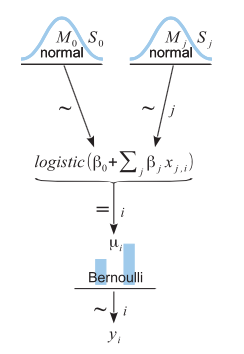

In [5]:
Image('images/fig21_2.png')

#### Predicting gender from weight alone

In [6]:
with pmc.Model() as model_weight:
    
    zbeta0 = pmc.Normal('zbeta0', mu=0, sd=2)
    zbetaj = pmc.Normal('zbetaj', mu=0, sd=2)
        
    p = pmc.invlogit(zbeta0 + zbetaj*zX[:,1])
        
    likelihood = pmc.Bernoulli('likelihood', p, observed=y.values)

In [7]:
with model_weight:
    trace1 = pmc.sample(10000)

Assigned NUTS to zbeta0
Assigned NUTS to zbetaj
 [-----------------100%-----------------] 10000 of 10000 complete in 4.1 sec

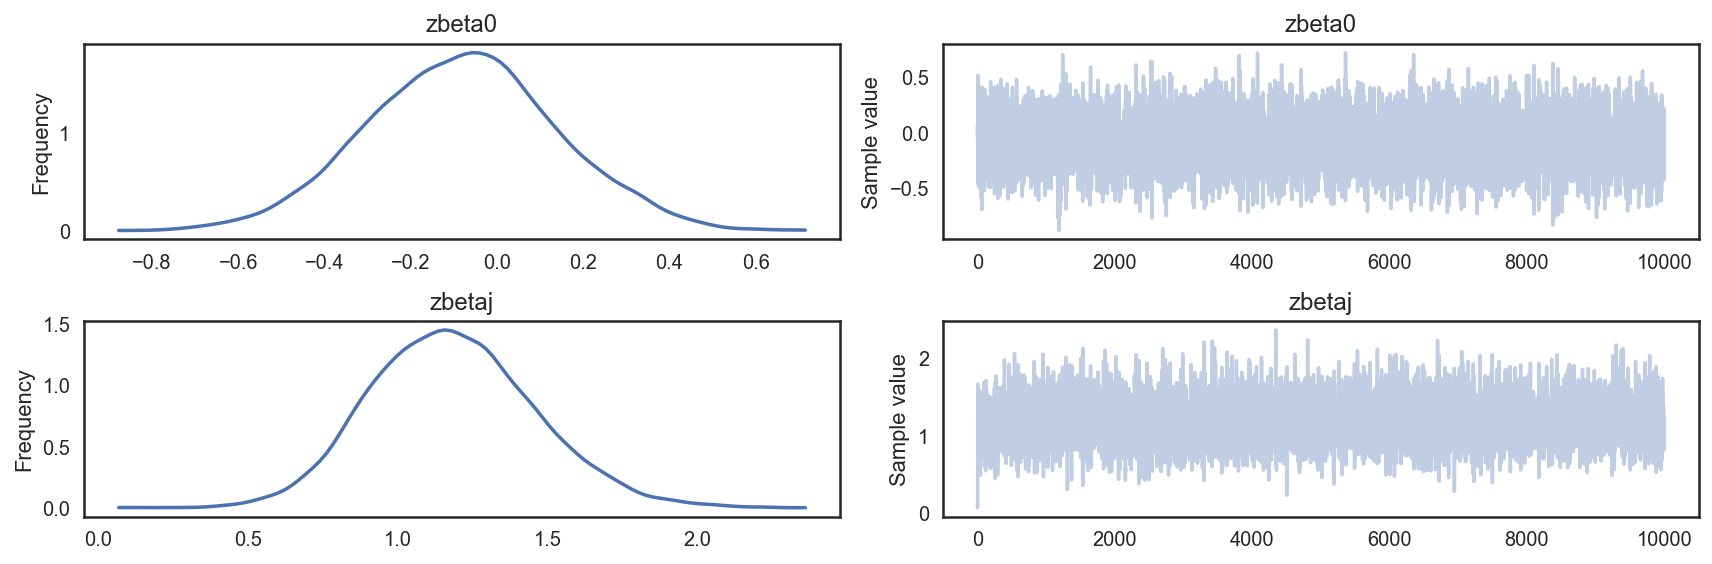

In [8]:
pmc.traceplot(trace1);

#### Figure 21.3

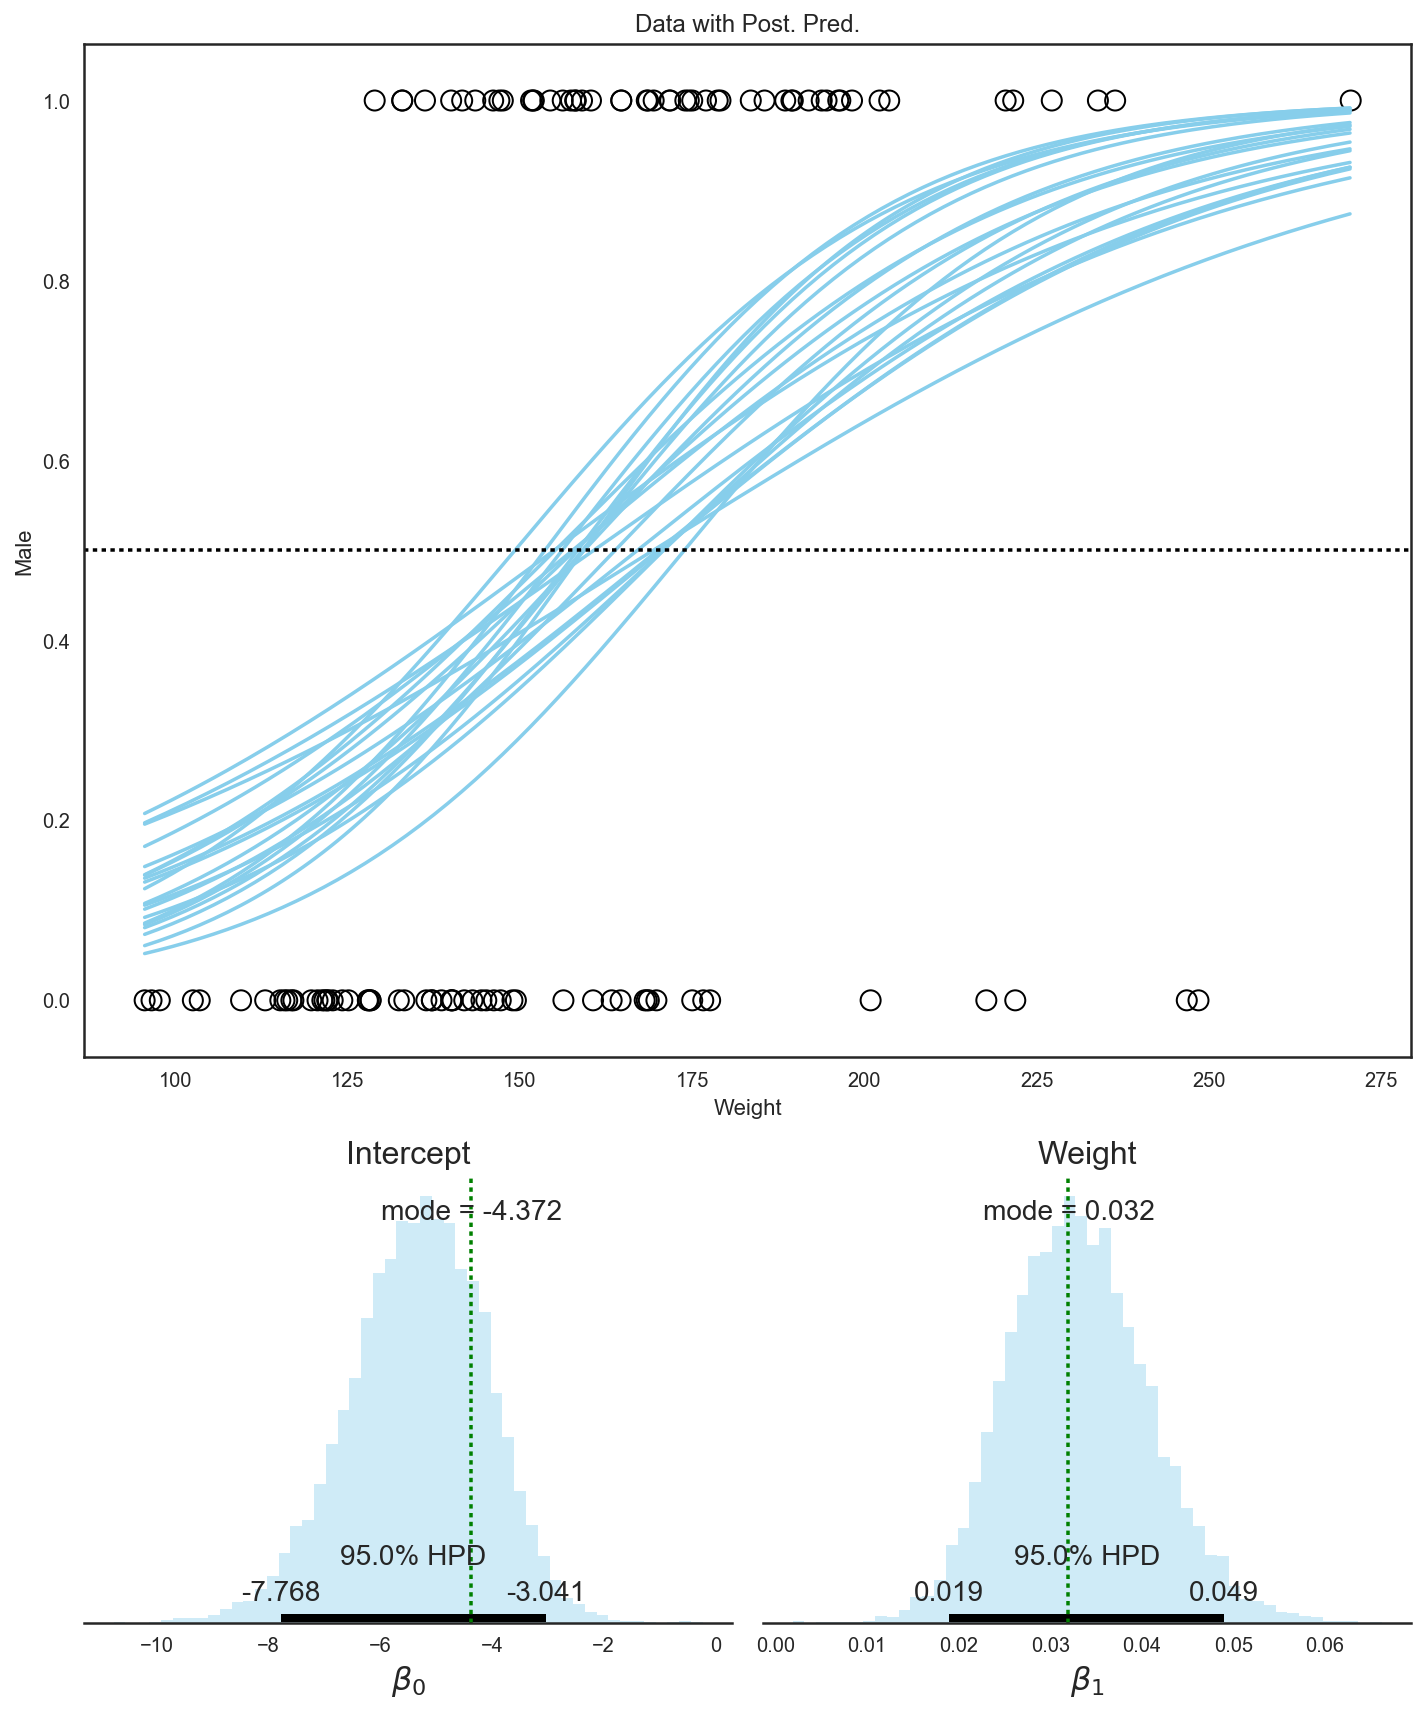

In [9]:
# Transform parameters back to original scale
beta0 = trace1['zbeta0'] - trace1['zbetaj']*meanx[1]/scalex[1]
betaj = (trace1['zbetaj']/scalex[1])

plt.figure(figsize=(10,12))
# Define gridspec
gs = gridspec.GridSpec(3, 4)
ax1 = plt.subplot(gs[:2,:4])
ax2 = plt.subplot(gs[2,:2])
ax3 = plt.subplot(gs[2,2:])

ax1.scatter(df.weight, df.male, s=100, edgecolor='k', facecolors='None', lw=1)

tr_len = len(trace1)
n_curves = 20
stepIdxVec = np.arange(100, tr_len, tr_len//n_curves)
weights = np.tile(np.arange(df.weight.min(), df.weight.max()).reshape(-1,1), (1,20))
ax1.plot(weights, expit(beta0[stepIdxVec] + betaj[stepIdxVec]*weights), c=color)

ax1.axhline(y=0.5, color='k', linestyle='dotted')
ax1.set_xlabel('Weight')
ax1.set_ylabel('Male')
ax1.set_title('Data with Post. Pred.')

plot_posterior(beta0, ax=ax2)
ax2.set_title('Intercept', fontdict=f_dict)
ax2.set_xlabel(r'$\beta_0$', fontdict=f_dict)

plot_posterior(betaj, ax=ax3)
ax3.set_title('Weight', fontdict=f_dict)
ax3.set_xlabel(r'$\beta_1$', fontdict=f_dict);

plt.tight_layout();

#### Predicting gender from weight and height

In [10]:
with pmc.Model() as model:
    
    zbeta0 = pmc.Normal('zbeta0', mu=0, sd=2)
    zbetaj = pmc.Normal('zbetaj', mu=0, sd=2, shape=(2))
        
    p = pmc.invlogit(zbeta0 + pmc.dot(zbetaj, zX.T))
        
    likelihood = pmc.Bernoulli('likelihood', p, observed=y.values)

In [11]:
with model:
    trace2 = pmc.sample(10000)

Assigned NUTS to zbeta0
Assigned NUTS to zbetaj
 [-----------------100%-----------------] 10000 of 10000 complete in 5.0 sec

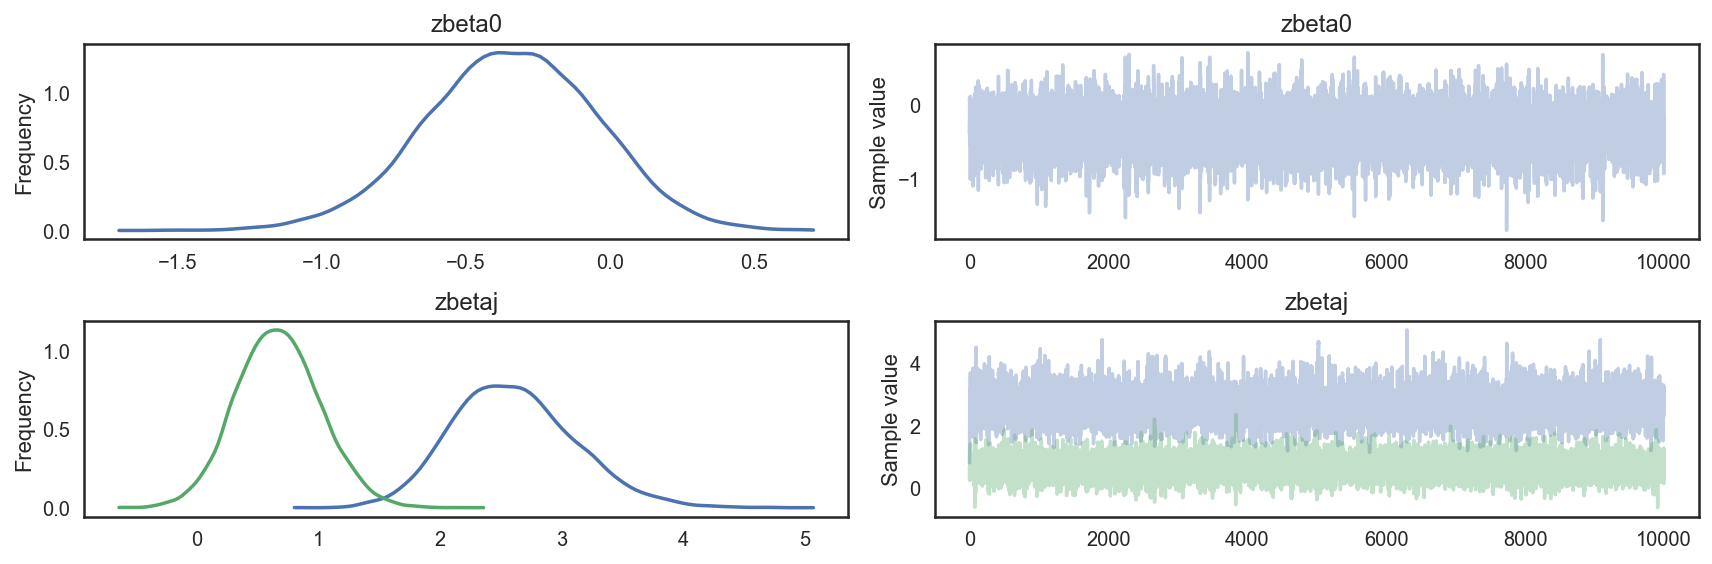

In [12]:
pmc.traceplot(trace2);

#### Figure 21.4

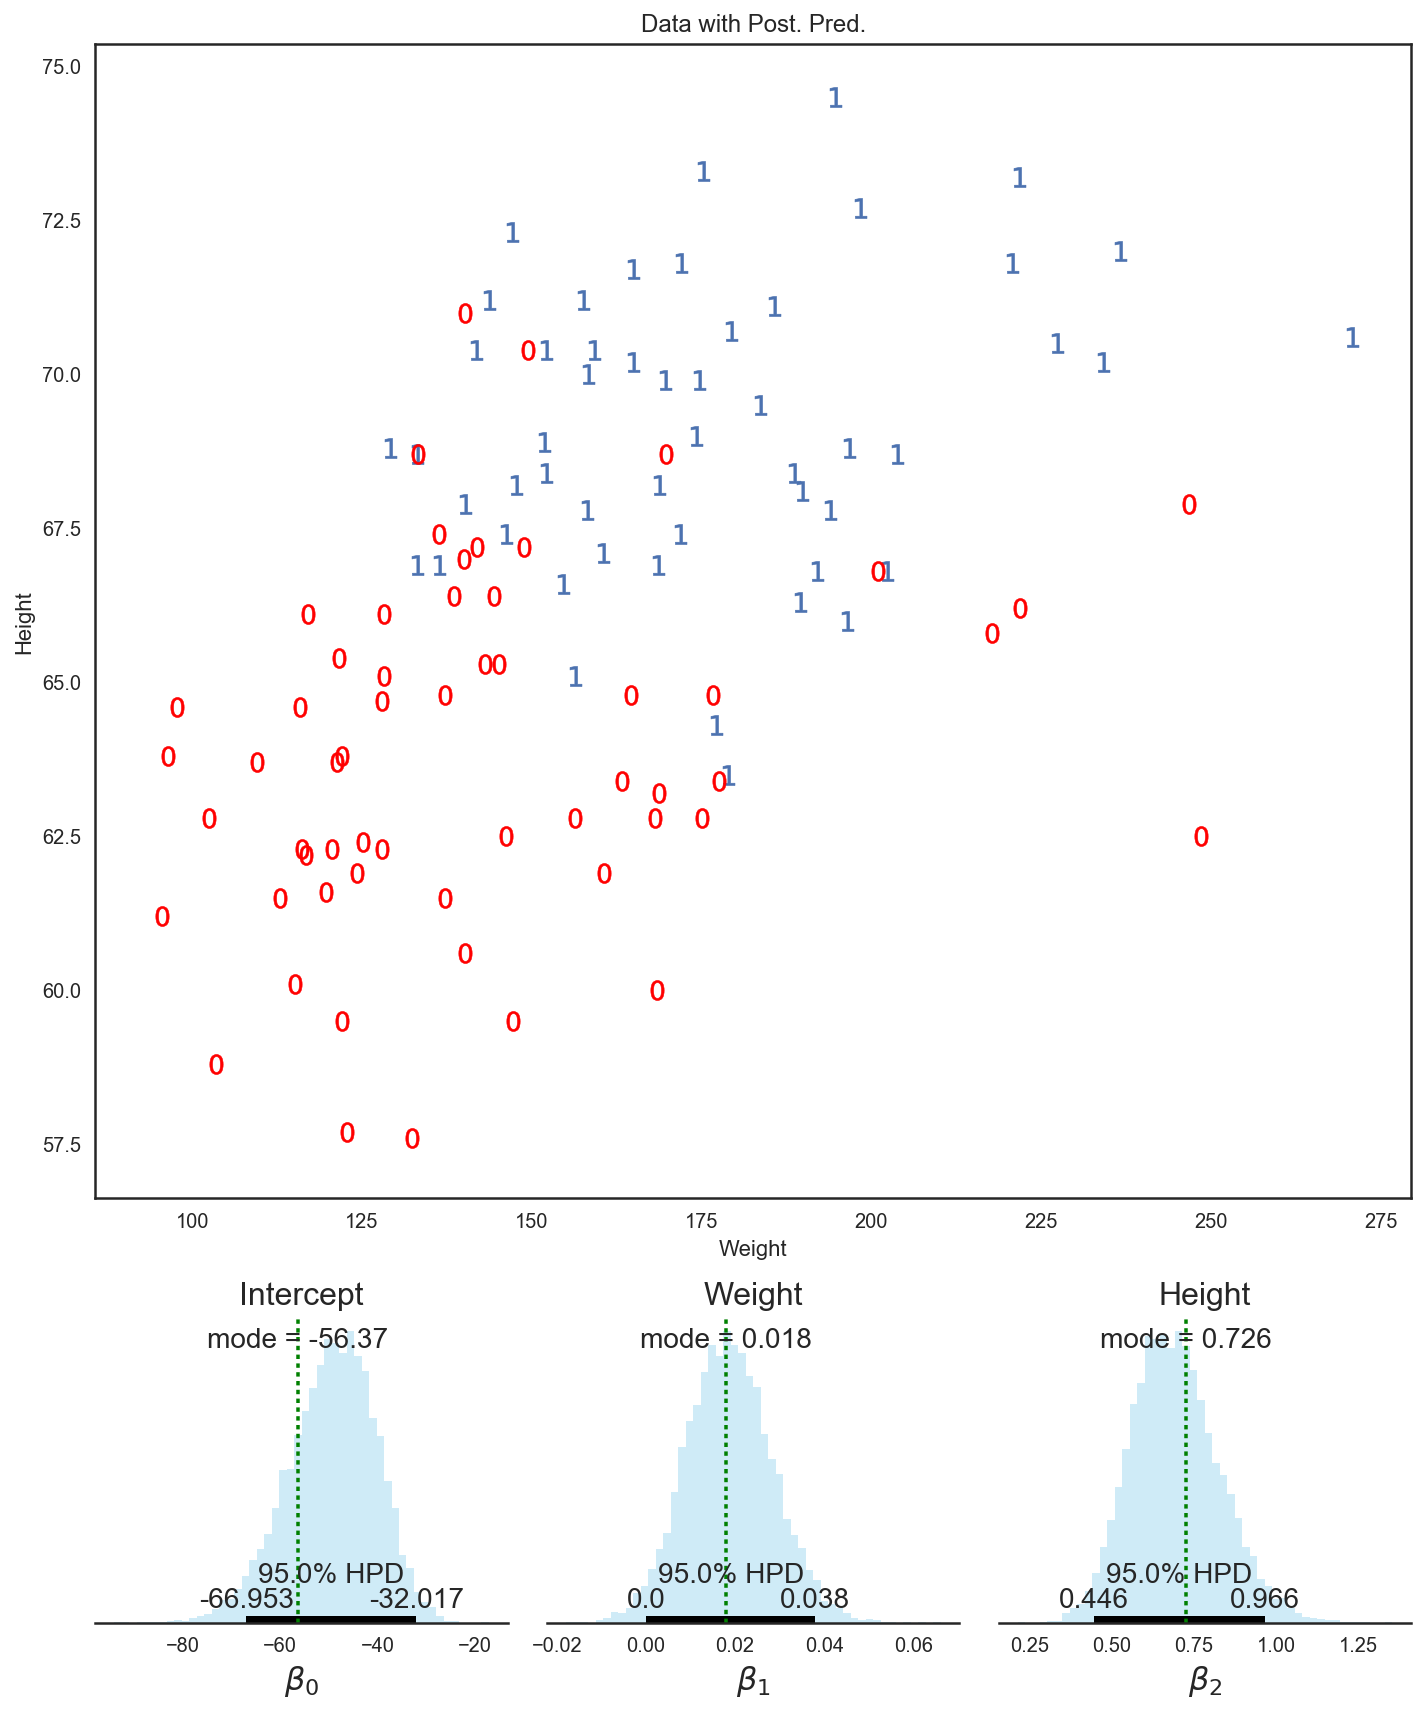

In [13]:
# Transform parameters back to original scale
beta0 = trace2['zbeta0'] - np.sum(trace2['zbetaj']*meanx/scalex, axis=1)
betaj = (trace2['zbetaj']/scalex)

plt.figure(figsize=(10,12))

# Define gridspec
gs = gridspec.GridSpec(4, 3)
ax1 = plt.subplot(gs[:3,:3])
ax2 = plt.subplot(gs[3,0])
ax3 = plt.subplot(gs[3,1])
ax4 = plt.subplot(gs[3,2])

mask = df.male == 1

ax1.scatter(df[mask].weight, df[mask].height, s=100, marker='$1$',)
ax1.scatter(df[~mask].weight, df[~mask].height, s=100, c='r', marker='$0$')
ax1.set_xlabel('Weight')
ax1.set_ylabel('Height')
ax1.set_title('Data with Post. Pred.')

plot_posterior(beta0, ax=ax2)
ax2.set_title('Intercept', fontdict=f_dict)
ax2.set_xlabel(r'$\beta_0$', fontdict=f_dict)

plot_posterior(betaj[:,1], ax=ax3)
ax3.set_title('Weight', fontdict=f_dict)
ax3.set_xlabel(r'$\beta_1$', fontdict=f_dict)

plot_posterior(betaj[:,0], ax=ax4)
ax4.set_title('Height', fontdict=f_dict)
ax4.set_xlabel(r'$\beta_2$', fontdict=f_dict);

plt.tight_layout();